In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import shapely
import rasterio.features
from PIL import Image

In [2]:
from flygym.util.config import raw_img_width_px
from flygym.util.data import sample_visual_path, ommatidia_id_map_path

In [3]:
retina_side_len_hex = 16  # side len of the bounding hexagon in unit of small hexagons
overall_layout = "vertical"  # whether we want the bounding to be tall or wide

In [4]:
def calc_area_in_hexagons(side_len):
    return 3 * side_len**2 - 3 * side_len + 1

print(
    f"There will be {calc_area_in_hexagons(retina_side_len_hex)} hexagons "
    "(ommatidia) in the bounding hexagon."
)

There will be 721 hexagons (ommatidia) in the bounding hexagon.


Let's first define the small hexagons on a uniform grid. The side length of the small hexagons is 1.

In [5]:
# first define the centers
centers = []
for n_hex_rows in range(int(2.5 * retina_side_len_hex)):
    offset = 0 if n_hex_rows % 2 == 0 else np.sqrt(3) / 2
    for n_hex_cols in range(int(2.5 * retina_side_len_hex)):
        centers.append([np.sqrt(3) * n_hex_cols + offset, 1.5 * n_hex_rows])
centers = np.array(centers)
max_len = len(centers) - 1 if len(centers) % 2 == 0 else len(centers)
centers[:, 0] -= np.median(centers[:max_len, 0])
centers[:, 1] -= np.median(centers[:max_len, 1])
if overall_layout == "vertical":
    centers = centers[:, ::-1]

In [6]:
# define the vertices of a hexagon with side length 1 around (0, 0)
hex_verts = np.array(
    [
        (-np.sqrt(3) / 2, -0.5),
        (-np.sqrt(3) / 2, 0.5),
        (0, 1),
        (np.sqrt(3) / 2, 0.5),
        (np.sqrt(3) / 2, -0.5),
        (0, -1),
        (-np.sqrt(3) / 2, -0.5),
    ]
)
if overall_layout == "vertical":
    hex_verts = hex_verts[:, ::-1]
hex_shapes = []

# get vertices of all hexagons
for center_x, center_y in centers:
    hex_shapes.append(hex_verts + np.array([center_x, center_y]))
hex_shapes = np.array(hex_shapes)

Define the large bounding hexagon

In [7]:
big_side_len = np.sqrt(3) * (retina_side_len_hex - 0.8)
bound_hexagon_verts = np.array(
    [
        [-big_side_len / 2, -big_side_len * np.sqrt(3) / 2],
        [big_side_len / 2, -big_side_len * np.sqrt(3) / 2],
        [big_side_len, 0],
        [big_side_len / 2, big_side_len * np.sqrt(3) / 2],
        [-big_side_len / 2, big_side_len * np.sqrt(3) / 2],
        [-big_side_len, 0],
        [-big_side_len / 2, -big_side_len * np.sqrt(3) / 2],
    ]
)
if overall_layout == "vertical":
    bound_hexagon_verts = bound_hexagon_verts[:, ::-1]

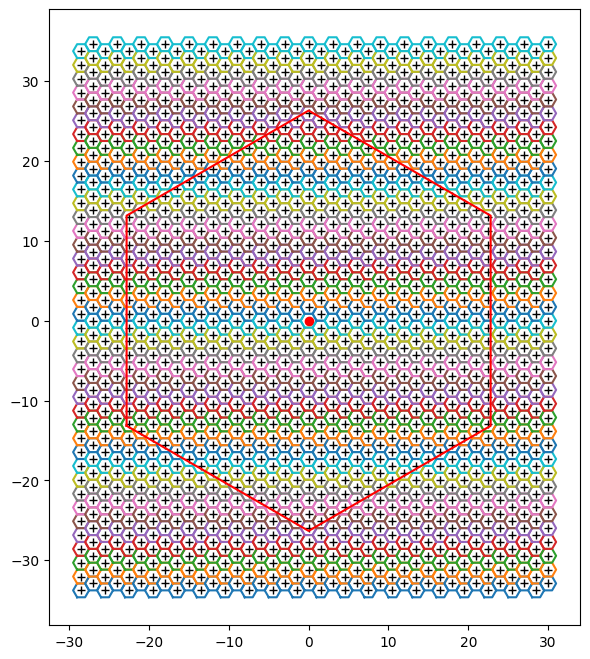

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(centers[:, 0], centers[:, 1], "+", color="black")
plt.plot([0], [0], "o", color="red")
for hex_shape in hex_shapes:
    plt.plot(hex_shape[:, 0], hex_shape[:, 1])
plt.plot(bound_hexagon_verts[:, 0], bound_hexagon_verts[:, 1], color="red")
plt.gca().set_aspect("equal")

Select small hexagons whose centers are inside the bounding hexagon

In [9]:
big_polygon = shapely.geometry.Polygon(bound_hexagon_verts)
is_inside = np.array([big_polygon.contains(shapely.geometry.Point(x)) for x in centers])

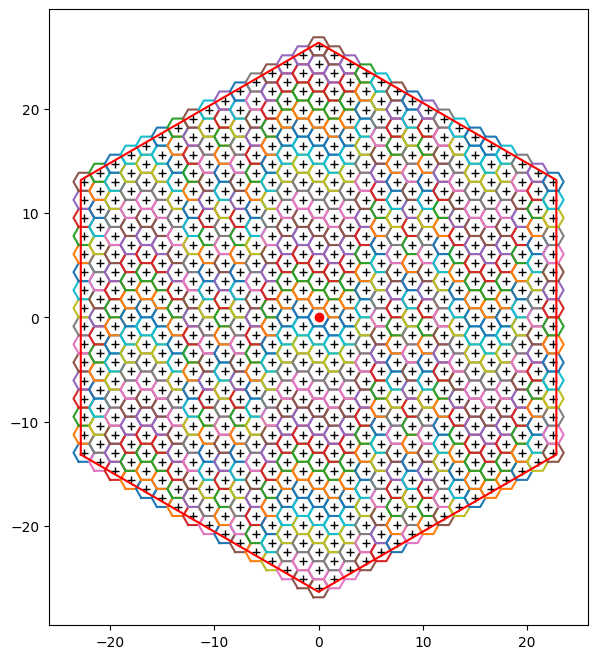

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(centers[is_inside, 0], centers[is_inside, 1], "+", color="black")
plt.plot([0], [0], "o", color="red")
for hex_shape in hex_shapes[is_inside]:
    plt.plot(hex_shape[:, 0], hex_shape[:, 1])
plt.plot(bound_hexagon_verts[:, 0], bound_hexagon_verts[:, 1], color="red")
plt.gca().set_aspect("equal")

Now, shift it so that a corner is at (0, 0). Scale it up from an arbitrary unit where the side length of the small hexagons is 1 to the actual size of the raster image.

In [11]:
hex_shapes_inside = hex_shapes[is_inside]
x_min, y_min = np.min(hex_shapes_inside.reshape(-1, 2), axis=0)
x_max, y_max = np.max(hex_shapes_inside.reshape(-1, 2), axis=0)
hex_shapes_inside[:, :, 0] -= x_min
hex_shapes_inside[:, :, 1] -= y_min

In [12]:
canvas_width_au = x_max - x_min
canvas_height_au = y_max - y_min

In [13]:
raw_img_height_px = 512
_raw_img_width_px = int(canvas_width_au / canvas_height_au * raw_img_height_px) + 1
if _raw_img_width_px % 2 == 1:
    _raw_img_width_px += 1
assert _raw_img_width_px == raw_img_width_px
print(f"raw_img_width_px: {raw_img_width_px}")

raw_img_width_px: 450


Rasterize this shape to generate a `hex_id_map` where the value of the pixel indicates which hexagon (ommatidium) it is in.

In [14]:
hex_shapes_inside_px = hex_shapes_inside * raw_img_height_px / canvas_height_au
polygons = [shapely.geometry.Polygon(x) for x in hex_shapes_inside_px]
indexed_polygons = [(x, i + 1) for i, x in enumerate(polygons)]
hex_id_map = rasterio.features.rasterize(
    indexed_polygons, out_shape=(raw_img_height_px, raw_img_width_px), default_value=0
)

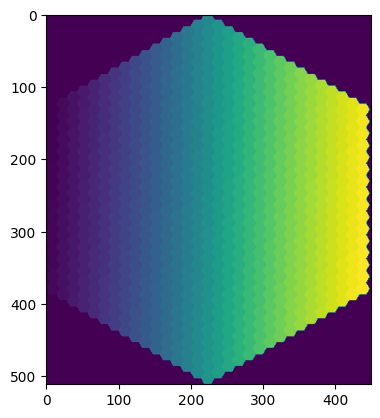

In [15]:
plt.imshow(hex_id_map)

Now, simulate how the fly actually sees an image:

In [16]:
img_arr = np.array(Image.open(sample_visual_path))

In [17]:
masks = np.array([hex_id_map == i + 1 for i in range(len(hex_shapes_inside))])
masks = np.moveaxis(masks, 0, -1)

In [18]:
processed_img = np.ones((raw_img_height_px, raw_img_width_px, 3), dtype=np.uint8) * 255
for i in range(len(polygons)):
    _mask = masks[:, :, i]
    pxls = img_arr[_mask, :]
    processed_img[_mask] = pxls.mean(axis=0).astype(np.uint8)

In [19]:
%%timeit
processed_img = np.ones((raw_img_height_px, raw_img_width_px, 3), dtype=np.uint8) * 255
for i in range(len(polygons)):
    _mask = masks[:, :, i]
    pxls = img_arr[_mask, :]
    processed_img[_mask] = pxls.mean(axis=0).astype(np.uint8)

435 ms ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 1.0, 'Simulated Image')

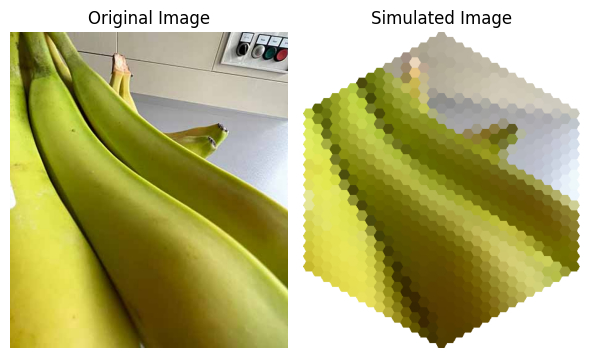

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(6, 5), tight_layout=True)
axs[0].imshow(img_arr)
axs[0].axis("off")
axs[0].set_title("Original Image")
axs[1].imshow(processed_img)
axs[1].axis("off")
axs[1].set_title("Simulated Image")

Make it faster with JIT with Numba. Remove the red band since the fly can't see it.

In [21]:
num_pixels_arr = masks.reshape((-1, len(polygons))).sum(axis=0)

@nb.njit(parallel=True)
def raw_image_to_hex_pxls(img_arr, num_pixels_arr, hex_id_map):
    vals = np.zeros((len(num_pixels_arr), 2))
    img_arr_flat = img_arr.reshape((-1, 3))
    hex_id_map_flat = hex_id_map.flatten()
    for i in nb.prange(hex_id_map_flat.size):
        hex_pxl_id = hex_id_map_flat[i] - 1
        if hex_pxl_id != -1:
            ch_idx = hex_pxl_id % 2
            vals[hex_pxl_id, ch_idx] += (
                img_arr_flat[i, ch_idx + 1] / num_pixels_arr[hex_pxl_id]
            )
    return vals

In [22]:
@nb.njit(parallel=True)
def hex_pxls_to_human_readable(vals, hex_id_map):
    processed_image_flat = np.zeros(hex_id_map.size, dtype=np.uint8) + 255
    hex_id_map_flat = hex_id_map.flatten().astype(np.int16)
    for i in nb.prange(hex_id_map_flat.size):
        hex_pxl_id = hex_id_map_flat[i] - 1
        if hex_pxl_id != -1:
            hex_pxl_val = vals[hex_pxl_id, :].max()
            processed_image_flat[i] = hex_pxl_val
    return processed_image_flat.reshape(hex_id_map.shape)

In [23]:
pxl_vals = raw_image_to_hex_pxls(img_arr, num_pixels_arr, hex_id_map)

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [24]:
%%timeit
pxl_vals = raw_image_to_hex_pxls(img_arr, num_pixels_arr, hex_id_map)

117 µs ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
human_image = hex_pxls_to_human_readable(pxl_vals, hex_id_map)

In [26]:
%%timeit
human_image = hex_pxls_to_human_readable(pxl_vals, hex_id_map)

133 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Check that we still have the same result

Text(0.5, 1.0, 'Simulated Image')

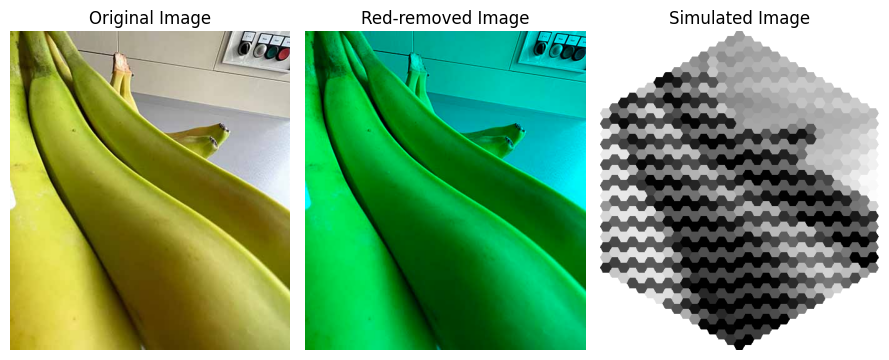

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(9, 5), tight_layout=True)
img_arr_nored = img_arr.copy()
img_arr_nored[:, :, 0] = 0
axs[0].imshow(img_arr)
axs[0].axis("off")
axs[0].set_title("Original Image")
axs[1].imshow(img_arr_nored)
axs[1].axis("off")
axs[1].set_title("Red-removed Image")
axs[2].imshow(human_image, vmin=0, vmax=255, cmap="gray")
axs[2].axis("off")
axs[2].set_title("Simulated Image")

Save hex pixel ID map

In [28]:
np.save(ommatidia_id_map_path, hex_id_map)